### Importing libraries and functions

In [46]:
from pyspark.sql import SparkSession
import pandas as pd
import os
import sys
sys.path.append('../')
from scripts.scrape_oldlistings import scrape_postcodes, scrape_postcodes_from_file, get_oldlisting_data, get_remaining_suburbs, get_remaining_oldlisting_data, convert_csv_to_parquet
from scripts.preprocess_oldlistings_pandas import create_forecast_template, split_by_gcc, split_domain_by_gcc
from scripts.preproccessing import add_data
from scripts.preproccessing import combine_SA2

# Functions for preprocessing
from scripts.preprocess_oldlistings_pandas import preprocess_olist
from scripts.preprocess_oldlistings_pandas import lowercase_string_attributes
from scripts.preprocess_oldlistings_pandas import preprocess_dates
from scripts.preprocess_oldlistings_pandas import preprocess_bbp
from scripts.preprocess_oldlistings_pandas import preprocess_address
from scripts.preprocess_oldlistings_pandas import preprocess_house_type
from scripts.preprocess_oldlistings_pandas import get_weekly_price

### Datascrape

In [2]:
#scrape_postcodes_from_file()

,suburb,postcode
0,Abbotsford,3067
1,Aberfeldie,3040
2,Aberfeldy,3825
3,Acheron,3714
4,Addington,3352
...,...,...
1698,Yeodene,3249
1699,Yinnar,3869
1700,Youanmite,3646
1701,Yundool,3727


In [3]:
#get_oldlisting_data()

Getting data for Abbotsford, 3067. Suburb 0 of 1703
num pages: 96
Getting data for Aberfeldie, 3040. Suburb 1 of 1703
num pages: 11
Getting data for Aberfeldy, 3825. Suburb 2 of 1703
Error 404: Not found https://www.oldlistings.com.au/real-estate/VIC/Aberfeldy/3825/rent/. Continuing with other URLs.
Getting data for Acheron, 3714. Suburb 3 of 1703
num pages: 1
Getting data for Addington, 3352. Suburb 4 of 1703
Error 404: Not found https://www.oldlistings.com.au/real-estate/VIC/Addington/3352/rent/. Continuing with other URLs.
Getting data for Agnes, 3962. Suburb 5 of 1703
num pages: 1
Getting data for Aireys+Inlet, 3231. Suburb 6 of 1703
num pages: 5
Getting data for Airport+West, 3042. Suburb 7 of 1703
num pages: 45
Getting data for Albanvale, 3021. Suburb 8 of 1703
num pages: 12
Getting data for Albert+Park, 3206. Suburb 9 of 1703
num pages: 47
Getting data for Alberton, 3971. Suburb 10 of 1703
num pages: 1
Getting data for Albion, 3020. Suburb 11 of 1703
num pages: 25
Getting data f

In [2]:
#get_remaining_suburbs()

In [9]:
#get_remaining_oldlisting_data()

Getting data for West+Melbourne, 3003. Suburb 0 of 97
num pages: 106
Getting data for Westmeadows, 3049. Suburb 1 of 97
num pages: 22
Getting data for Westmere, 3351. Suburb 2 of 97
num pages: 1
Getting data for Wheelers+Hill, 3150. Suburb 3 of 97
num pages: 48
Getting data for White+Hills, 3550. Suburb 4 of 97
num pages: 15
Getting data for Whitfield, 3733. Suburb 5 of 97
num pages: 1
Getting data for Whitlands, 3733. Suburb 6 of 97
Error 404: Not found https://www.oldlistings.com.au/real-estate/VIC/Whitlands/3733/rent/. Continuing with other URLs.
Getting data for Whittington, 3219. Suburb 7 of 97
num pages: 14
Getting data for Whittlesea, 3757. Suburb 8 of 97
num pages: 14
Getting data for Whorouly, 3735. Suburb 9 of 97
num pages: 2
Getting data for Wickliffe, 3379. Suburb 10 of 97
Error 404: Not found https://www.oldlistings.com.au/real-estate/VIC/Wickliffe/3379/rent/. Continuing with other URLs.
Getting data for Wilby, 3728. Suburb 11 of 97
num pages: 1
Getting data for Willaura, 

### Initial handling of the data

In [7]:
convert_csv_to_parquet()

### Preprocessing the data

#### 1. Splitting Data

In [9]:
# sdf = spark.read.parquet("../data/curated/properties.parquet")
# sdf.show()
# pandas = sdf.toPandas()

# combined = combine_SA2(pandas)
# print(combined.head())
split_by_gcc(spark)
split_domain_by_gcc(spark)

/mnt/c/Users/pyrou/Documents/GitHub/project-2-group-real-estate-industry-project-31/notebooks/../scripts/preproccessing.py:162: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:7844

  gdf_joined = gpd.sjoin(gdf_points, sf, how='left', predicate='within') # join our SA2 points with all listings


#### 2. Final Preprocessing

In [2]:
# Defining datasets and inputs
read_dir = '../data/raw/oldlisting/'
out_dir = '../data/raw/oldlisting/'

# Creating the fdirectory if it doesn't yet exist
if not os.path.exists(out_dir):
        os.makedirs(out_dir)

# Adding all wanted dataset names into list 
DATASETS = ['gm_c+a_oldlisting.csv', 'rv_c+a_oldlisting.csv']


*Can run either block of code to preprocess. They both run the same functions*

In [ ]:
# Preprocesses the given datasets and saves them into the given directory

#preprocess_olist(read_dir, out_dir, DATASETS)

In [3]:
# Applies preprocessing steps to all datasets
for i, region in enumerate(DATASETS):

    print(f"\n{i+1}. Preprocessing {region}...\n")
        
    # Step 1: Read in dataframe
    listings_df = pd.read_csv(f"{read_dir}{region}")


    # Step 2: Drops any index columns that were added on when opening and saving dataset previously
    cols_to_remove = [col for col in listings_df.columns if "Unnamed:" in col]
    listings_df = listings_df.drop(cols_to_remove, axis=1)


    # Step 3: Dropping duplicates rows
    listings_df = listings_df.drop_duplicates()  # nothing gets dropped but will keep this anyways
    

    # Step 4: Lowercasing all the values that are strings
    listings_df = lowercase_string_attributes(listings_df) # only lowercases 3 cols. There are more string cols


    # Step 5: Formatting suburb names for readability
    listings_df["suburb"] = listings_df["suburb"].str.replace("+", " ")


    # Step 6: Converting dates from [yyyy, MM] to [yyyy]
    listings_df['dates'] = listings_df['dates'].apply(preprocess_dates)


    # Step 7: Handling incorrect or missing values for no. of beds, baths and parking spaces
    listings_df = preprocess_bbp(listings_df)


    # Step 8: Formatting address into "House No., Street Name"
    listings_df = preprocess_address(listings_df) # need to add 1 more line to remove comma from end of street names


    # Step 9: Filtering the house types
    listings_df = preprocess_house_type(listings_df)


    # Step 10: Converting price to weekly cost
    listings_df = get_weekly_price(listings_df)

    # These only for spark dataframes??
    print(listings_df.head())
    # Saving the finalised dataframes into their respective directories
    if region == 'gm_c+a_oldlisting.csv':
        listings_df.to_csv(f"{out_dir}gm_oldlisting_final.csv", index=False)
    else:
        listings_df.to_csv(f"{out_dir}rv_oldlisting_final.csv", index=False)



1. Preprocessing gm_c+a_oldlisting.csv...

        suburb  postcode              address   latitude   longitude  beds  \
0  albert park      3206  21 faussett street  -37.842008  144.955458   2.0   
1  albert park      3206  21 faussett street  -37.842008  144.955458   2.0   
2  albert park      3206  21 faussett street  -37.842008  144.955458   2.0   
3  albert park      3206  21 faussett street  -37.842008  144.955458   2.0   
5  albert park      3206  21 faussett street  -37.842008  144.955458   2.0   

   baths  parking property_type date_available  SA2_CODE21         GCC_NAME21  \
0    1.0      1.0         house           2024   206051128  Greater Melbourne   
1    1.0      1.0         house           2024   206051128  Greater Melbourne   
2    1.0      1.0         house           2023   206051128  Greater Melbourne   
3    1.0      1.0         house           2021   206051128  Greater Melbourne   
5    1.0      1.0         house           2021   206051128  Greater Melbourne   



### Extra Section

In [47]:
# Merge Greater Melbourne Data
read_dir = '../data/raw/'

gm_oldlisting_df = pd.read_csv(f"{read_dir}oldlisting/gm_oldlisting_final.csv")
gm_domain_df = pd.read_csv(f"{read_dir}domain/gm_c+a_domain.csv")

gm_oldlisting_df = gm_oldlisting_df[['SA2_CODE21', 'GCC_NAME21', 'suburb', 'postcode', 'address',
                                    'latitude','longitude', 'beds','baths','parking',
                                    'dist_to_city', 'dist_to_education',
                                    'dist_to_parks_and_gardens', 'dist_to_train_station',
                                    'dist_to_healthcare', 'date_available', 'weekly_cost']]
gm_domain_df = gm_domain_df[['SA2_CODE21', 'GCC_NAME21', 'suburb', 'postcode', 'address',
                                    'latitude','longitude', 'beds','baths','parking',
                                    'dist_to_city', 'dist_to_education',
                                    'dist_to_parks_and_gardens', 'dist_to_train_station',
                                    'dist_to_healthcare', 'date_available', 'weekly_cost']]

all_gm_df = pd.concat([gm_oldlisting_df, gm_domain_df], axis=0, ignore_index=True)

In [48]:
# Merge Rest of Vic Data
read_dir = '../data/raw/'

rv_oldlisting_df = pd.read_csv(f"{read_dir}oldlisting/rv_oldlisting_final.csv")
rv_domain_df = pd.read_csv(f"{read_dir}domain/rv_c+a_domain.csv")

rv_oldlisting_df = rv_oldlisting_df[['SA2_CODE21', 'GCC_NAME21', 'suburb', 'postcode', 'address',
                                    'latitude','longitude', 'beds','baths','parking',
                                    'dist_to_city', 'dist_to_education',
                                    'dist_to_parks_and_gardens', 'dist_to_train_station',
                                    'dist_to_healthcare', 'date_available', 'weekly_cost']]
rv_domain_df = rv_domain_df[['SA2_CODE21', 'GCC_NAME21', 'suburb', 'postcode', 'address',
                                    'latitude','longitude', 'beds','baths','parking',
                                    'dist_to_city', 'dist_to_education',
                                    'dist_to_parks_and_gardens', 'dist_to_train_station',
                                    'dist_to_healthcare', 'date_available', 'weekly_cost']]

all_rv_df = pd.concat([rv_oldlisting_df, rv_domain_df], axis=0, ignore_index=True)

#### Add External Datasets

In [49]:
# Prep Greater Melbourne data to merge with External Data 
all_gm_df.rename(columns={'date_available': 'year'}, inplace=True)
all_gm_df['year'] = all_gm_df['year'].astype(str)
all_gm_df = combine_SA2(all_gm_df)

/mnt/c/Users/pyrou/Documents/GitHub/project-2-group-real-estate-industry-project-31/notebooks/../scripts/preproccessing.py:167: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:7844

  gdf_joined = gpd.sjoin(gdf_points, sf, how='left', predicate='within') # join our SA2 points with all listings


In [50]:

# Prep Rest of Vic data with External Data
all_rv_df.rename(columns={'date_available': 'year'}, inplace=True)
all_rv_df['year'] = all_rv_df['year'].astype(str)
all_rv_df = combine_SA2(all_rv_df)

/mnt/c/Users/pyrou/Documents/GitHub/project-2-group-real-estate-industry-project-31/notebooks/../scripts/preproccessing.py:167: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:7844

  gdf_joined = gpd.sjoin(gdf_points, sf, how='left', predicate='within') # join our SA2 points with all listings


In [51]:
gm_with_external_df = add_data(all_gm_df)
rv_with_external_df = add_data(all_rv_df)

#### Create Forecast Template, to predict price on 

In [52]:
# Create DataFrame of Years to append
years = ["2025", "2026", "2027", "2028", "2029"]
years_df = pd.DataFrame(years, columns=["year"])

# Create Dummy Key to Cross Join
years_df['key'] = 1

In [53]:
unique_gm_properties_df = pd.DataFrame(all_gm_df.drop_duplicates(["address"]))
unique_rv_properties_df = pd.DataFrame(all_rv_df.drop_duplicates(["address"]))

unique_gm_properties_df.drop(['year', 'weekly_cost'], axis=1, inplace=True)
unique_rv_properties_df.drop(['year', 'weekly_cost'], axis=1, inplace=True)

# Create Dummy Key to Cross Join
unique_gm_properties_df['key'] = 1
unique_rv_properties_df['key'] = 1

In [54]:
gm_template_df = pd.merge(unique_gm_properties_df, years_df, on='key')
rv_template_df = pd.merge(unique_rv_properties_df, years_df, on='key')

# Drop Dummy Variable
gm_template_df.drop('key', axis=1, inplace=True)
rv_template_df.drop('key', axis=1, inplace=True)

list(gm_template_df.columns)

['SA2_CODE21_left',
 'GCC_NAME21_left',
 'suburb',
 'postcode',
 'address',
 'latitude',
 'longitude',
 'beds',
 'baths',
 'parking',
 'dist_to_city',
 'dist_to_education',
 'dist_to_parks_and_gardens',
 'dist_to_train_station',
 'dist_to_healthcare',
 'point',
 'SA2_CODE21_right',
 'SA2_NAME21',
 'GCC_NAME21_right',
 'AREASQKM21',
 'num_homeless_persons',
 'avg_household_size',
 'num_businesses',
 'median_income',
 'median_age',
 'median_weekly_rent',
 'percent_aboriginal_torres_strait_islander',
 'percent_au_citizen',
 'percent_overseas_born',
 'percent_rental_properties',
 'population',
 'percent_unemployed',
 'year']

In [55]:
gm_template_external_df = add_data(gm_template_df)
rv_template_external_df = add_data(rv_template_df)

#### Drop Redundant Columns and Save

In [56]:
# Define output directory
out_dir = '../data/curated/final_datasets/'
template_out_dir =  '../data/curated/forecast/'

if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
if not os.path.exists(template_out_dir):
    os.makedirs(template_out_dir)

In [57]:
COLS_TO_DROP = ['SA2_CODE21_left', 'GCC_NAME21_left', 'suburb', 'postcode', 'address', 'latitude',
                'longitude', 'point', 'SA2_CODE21_right', "SA2_NAME21", "GCC_NAME21_right",
                'AREASQKM21']

In [58]:
# Drop Columns
gm_with_external_df.drop(columns=COLS_TO_DROP, axis=1, inplace=True)
rv_with_external_df.drop(columns=COLS_TO_DROP, axis=1, inplace=True)

gm_template_external_df.drop(columns=COLS_TO_DROP, axis=1, inplace=True)
rv_template_external_df.drop(columns=COLS_TO_DROP, axis=1, inplace=True)


In [59]:
# Save Data to CSV
gm_with_external_df.to_csv(f"{out_dir}greater_melbourne_train.csv", index=False)
rv_with_external_df.to_csv(f"{out_dir}rest_of_vic_train.csv", index=False)

gm_template_external_df.to_csv(f"{template_out_dir}greater_melbourne_predict.csv", index=False)
rv_template_external_df.to_csv(f"{template_out_dir}rest_of_vic_predict.csv", index=False)

#### Create Pairs Plots

In [63]:
import seaborn as sns

In [64]:
EXTERNAL_COLS = ['num_homeless_persons',
                'avg_household_size',
                'num_businesses',
                'median_income',
                'median_age',
                'median_weekly_rent',
                'percent_aboriginal_torres_strait_islander',
                'percent_au_citizen',
                'percent_overseas_born',
                'percent_rental_properties',
                'population',
                'percent_unemployed',
                'year']

In [68]:
df = pd.read_csv('../data/curated/final_datasets/greater_melbourne_train.csv')
df = df[EXTERNAL_COLS]

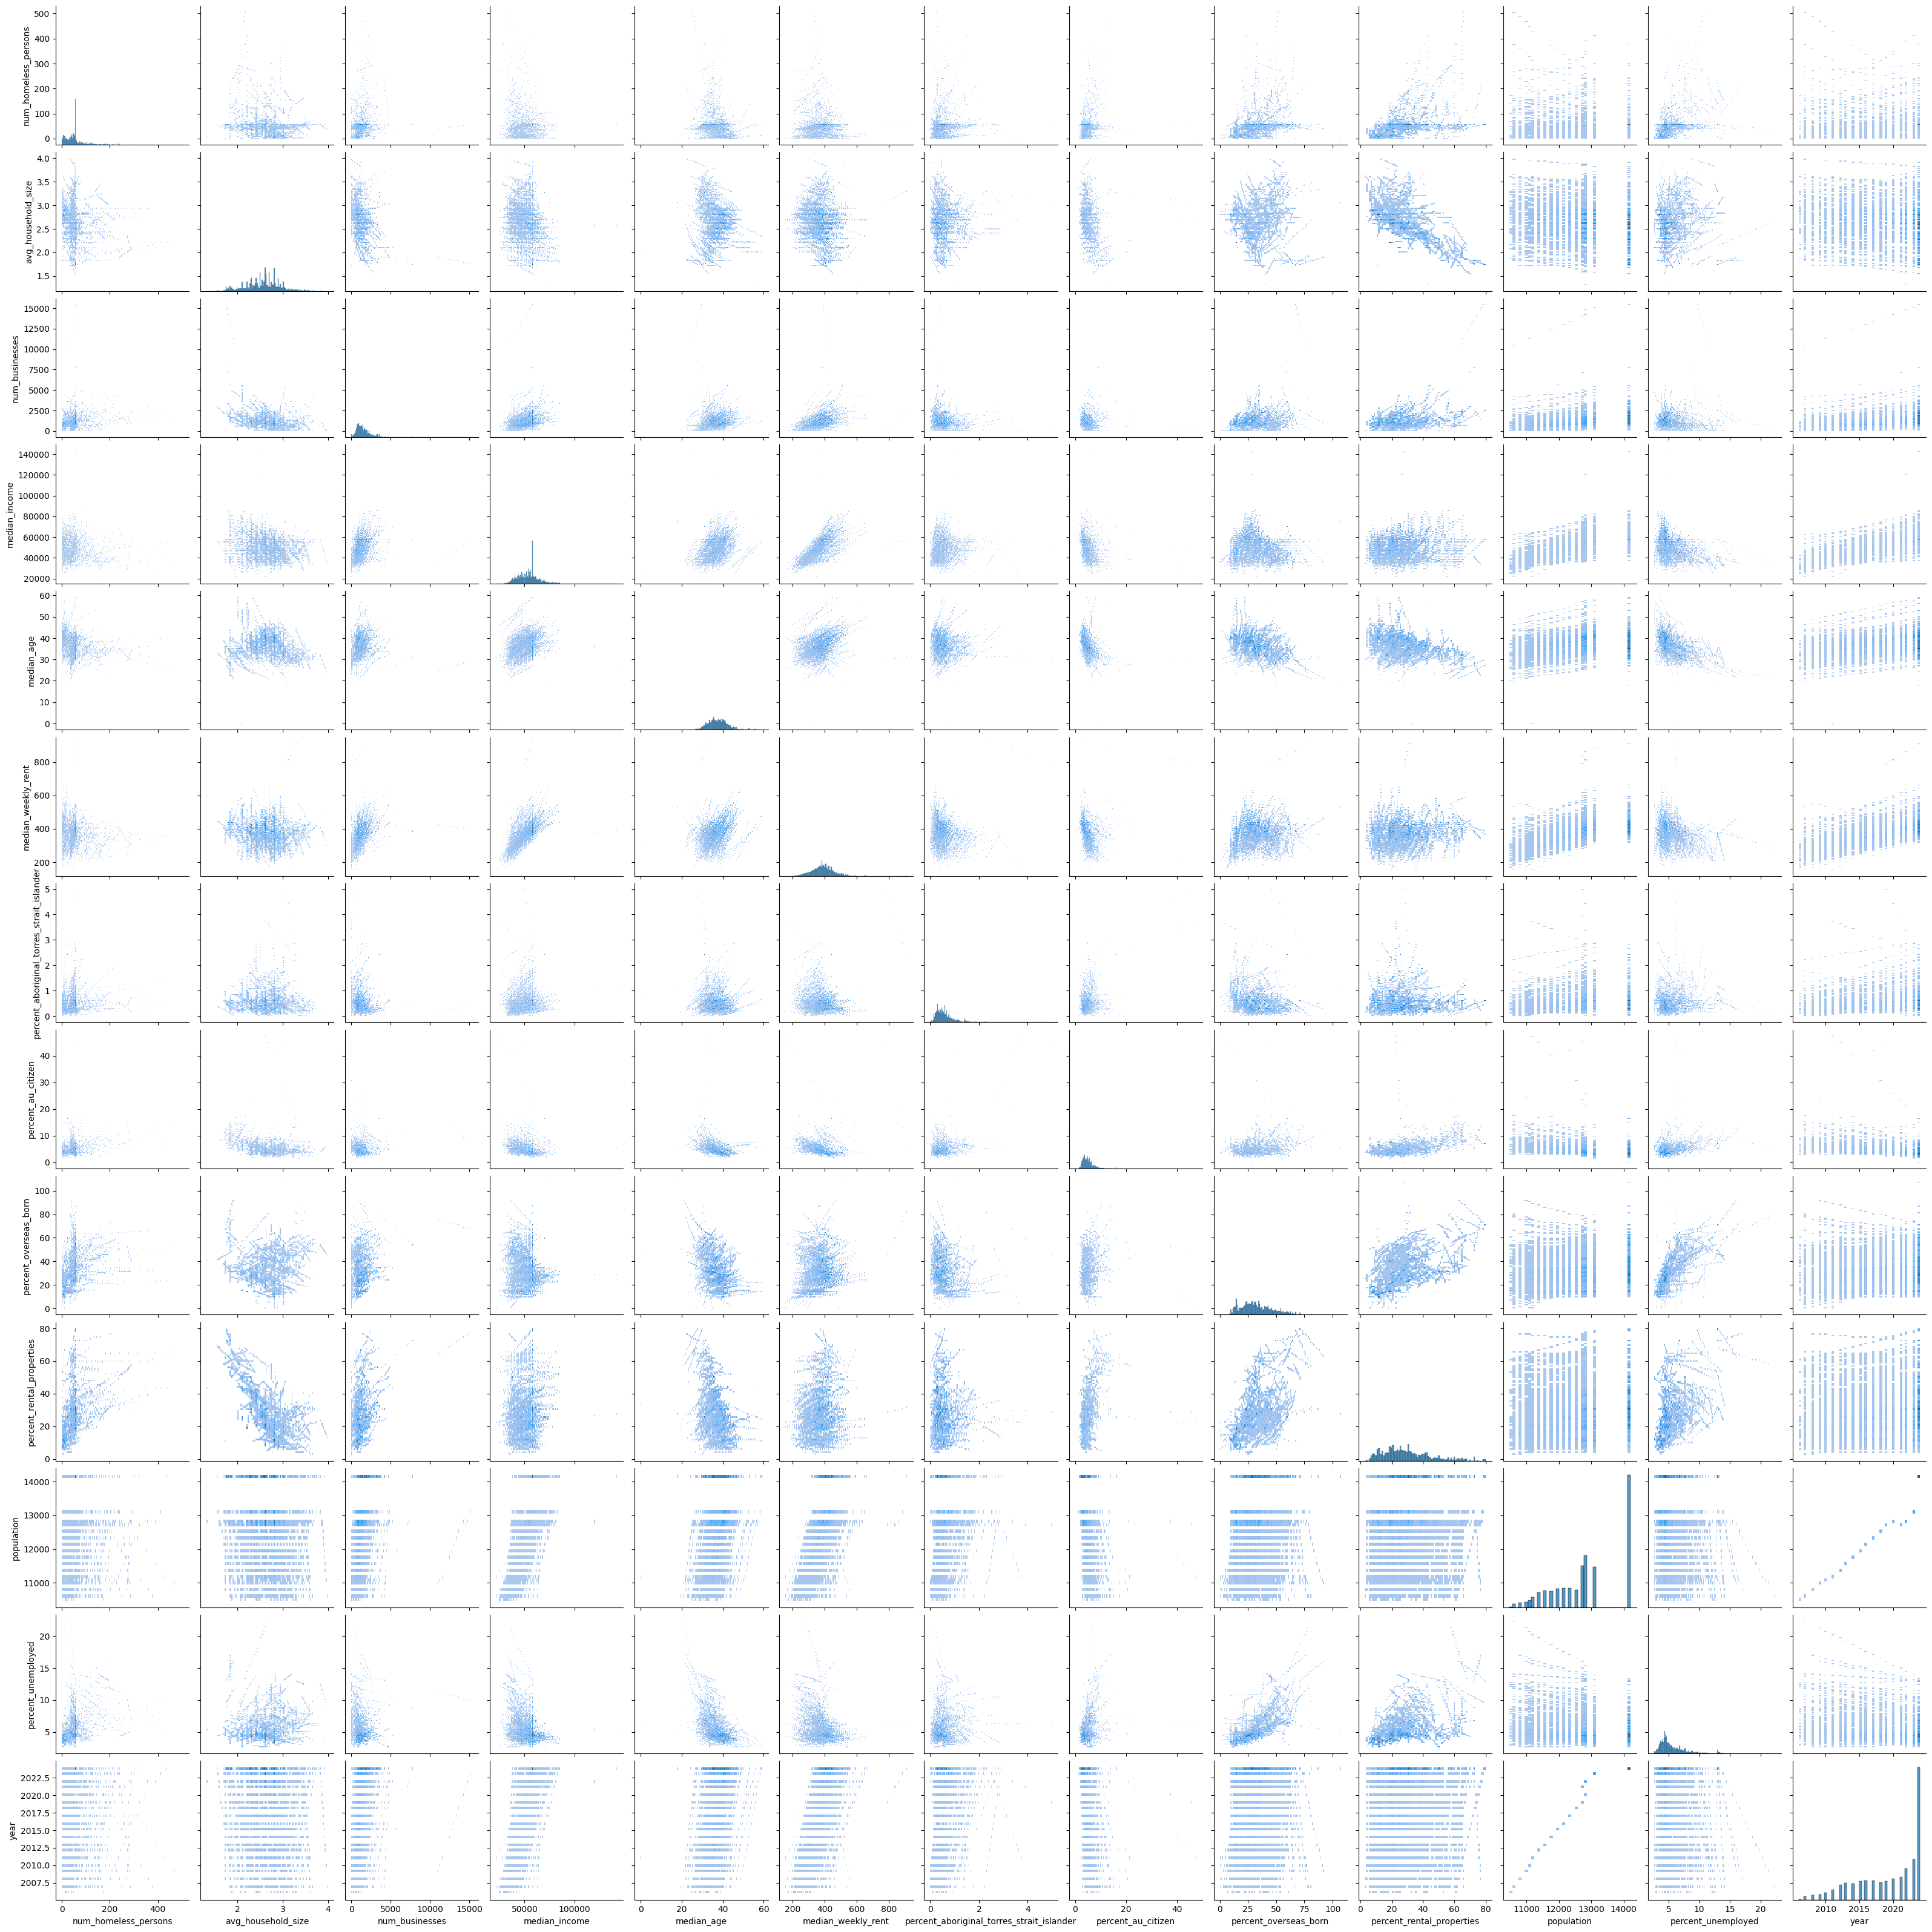

In [69]:
sns.pairplot(df, kind="hist")